# CPSC 392 Final Project, Fall 2022
### Gilberto Arellano
### Student ID: 1801074

In [1178]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

# Pre-processing
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.linear_model import RidgeCV, LassoCV 
from sklearn.mixture import GaussianMixture

# Metrics
from sklearn.metrics._plot.roc_curve import plot_roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, plot_confusion_matrix, f1_score, recall_score, precision_score

In [1179]:
# Importing data
fields = ['GenderSelect', 'Country', 'Age', 'EmploymentStatus', 'CodeWriter', 'StudentStatus', 'CurrentJobTitleSelect', 'LanguageRecommendationSelect', 'LearningDataScienceTime', 'TimeSpentStudying', 'FormalEducation', 'CompensationAmount', 'JobHuntTime', 'EmployerSearchMethod', 'WorkToolsSelect']
df = pd.read_csv("Datasets/multipleChoiceResponses.csv", usecols = fields , encoding = 'latin-1')

df.head()

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,CodeWriter,CurrentJobTitleSelect,LanguageRecommendationSelect,LearningDataScienceTime,TimeSpentStudying,FormalEducation,EmployerSearchMethod,WorkToolsSelect,CompensationAmount,JobHuntTime
0,"Non-binary, genderqueer, or gender non-conforming",NaN,NaN,Employed full-time,NaN,Yes,DBA/Database Engineer,F#,NaN,NaN,Bachelor's degree,I visited the company's Web site and found a j...,"Amazon Web services,Oracle Data Mining/ Oracle...",NaN,NaN
1,Female,United States,30.0,"Not employed, but looking for work",NaN,NaN,NaN,Python,1-2 years,2 - 10 hours,Master's degree,NaN,NaN,NaN,NaN
2,Male,Canada,28.0,"Not employed, but looking for work",NaN,NaN,NaN,R,1-2 years,2 - 10 hours,Master's degree,NaN,NaN,NaN,1-2
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,Yes,Operations Research Practitioner,Python,NaN,NaN,Master's degree,NaN,"Amazon Machine Learning,Amazon Web services,Cl...","250,000",NaN
4,Male,Taiwan,38.0,Employed full-time,NaN,Yes,Computer Scientist,Python,NaN,NaN,Doctoral degree,A tech-specific job board,"C/C++,Jupyter notebooks,MATLAB/Octave,Python,R...",NaN,NaN


In [1180]:
# Cleaning up the data

# Simplify data in GenderSelect
df = df[df['GenderSelect'].isin(['Male','Female'])]

# Only United States Participants
df = df[df['Country'] == 'United States']

# Drop those who didnt input their age
df = df.dropna(subset=['Age'])

# Drop 'prefer not to answer' for FormalEducation
df = df[~df['FormalEducation'].isin(['I prefer not to answer'])]

# Drop 'Some other way' for EmployerSearchMethod
df = df[~df['EmployerSearchMethod'].isin(['Some other way'])]

# Simplify EmploymentStatus, if employed: 1, else: 0
df = df[~df['EmploymentStatus'].isin(['I prefer not to say'])]
df['isEmployed'] = df['EmploymentStatus'].apply(lambda x: 1 if any(s in x for s in ['full-time', 'freelancer']) else 0)

# Convert StudentStatus null values to 0
#df['StudentStatus'] = df['StudentStatus'].map(lambda x: 1 if x == "Yes" else 0)
df['StudentStatus'] = df['StudentStatus'].astype(str).apply(lambda x: 1 if "Yes" in x else 0)

# To keep the students, conver their salary to 0. Prevents their rows being dropped when using df.dropna()
selected_rows = df.loc[df["StudentStatus"] == 1]
df.loc[selected_rows.index, "CompensationAmount"] = 0

# If the value is a string, remove their comma and convert to an integer
df = df.dropna(subset=['CompensationAmount']) # Drop any responses that didnt include their salary
df['CompensationAmount'] = df['CompensationAmount'].apply(lambda x: int(float(x.replace(',', '')) if isinstance(x, str) else x))

In [1181]:
# Simplifying labels
df['FormalEducation'] = df['FormalEducation'].replace('I did not complete any formal education past high school', 'high_school')
df['FormalEducation'] = df['FormalEducation'].replace('Some college/university study without earning a bachelor\'s degree', 'some_college')
df['FormalEducation'] = df['FormalEducation'].replace('Professional degree', 'professional')
df['FormalEducation'] = df['FormalEducation'].replace('Bachelor\'s degree', 'bachelors')
df['FormalEducation'] = df['FormalEducation'].replace('Master\'s degree', 'masters')
df['FormalEducation'] = df['FormalEducation'].replace('Doctoral degree', 'PhD')

df['EmployerSearchMethod'] = df['EmployerSearchMethod'].replace('A career fair or on-campus recruiting event', 'campus_recruitment')
df['EmployerSearchMethod'] = df['EmployerSearchMethod'].replace('A friend, family member, or former colleague told me', 'referral')
df['EmployerSearchMethod'] = df['EmployerSearchMethod'].replace(['A general-purpose job board', 'A tech-specific job board', 'I visited the company\'s Web site and found a job listing there'], 'job_board')
df['EmployerSearchMethod'] = df['EmployerSearchMethod'].replace(['I was contacted directly by someone at the company (e.g. internal recruiter)', 'An external recruiter or headhunter'], 'recruiter')

In [1182]:
# Create dummies for GenderSelect, FormalEducation and EmployerSearchMethod
dummies = pd.get_dummies(df['GenderSelect'])
df = pd.concat([df, dummies], axis = 1)
df = df.drop('GenderSelect', 1)

dummies = pd.get_dummies(df['FormalEducation'])
df = pd.concat([df, dummies], axis = 1)
df = df.drop('FormalEducation', 1)

dummies = pd.get_dummies(df['EmployerSearchMethod'])
df = pd.concat([df, dummies], axis = 1)
df = df.drop('EmployerSearchMethod', 1)

In [1183]:
df.head()

,Country,Age,EmploymentStatus,StudentStatus,CodeWriter,CurrentJobTitleSelect,LanguageRecommendationSelect,LearningDataScienceTime,TimeSpentStudying,WorkToolsSelect,...,PhD,bachelors,high_school,masters,professional,some_college,campus_recruitment,job_board,recruiter,referral
3,United States,56.0,"Independent contractor, freelancer, or self-em...",0,Yes,Operations Research Practitioner,Python,NaN,NaN,"Amazon Machine Learning,Amazon Web services,Cl...",...,0,0,0,1,0,0,0,0,0,0
15,United States,58.0,"Independent contractor, freelancer, or self-em...",0,Yes,DBA/Database Engineer,R,NaN,NaN,"C/C++,IBM Cognos,MATLAB/Octave,Microsoft Excel...",...,0,0,0,1,0,0,0,0,0,0
22,United States,33.0,Employed full-time,0,Yes,Scientist/Researcher,Matlab,NaN,NaN,"MATLAB/Octave,Python",...,1,0,0,0,0,0,0,0,0,1
34,United States,35.0,Employed full-time,0,Yes,Engineer,Python,NaN,NaN,"MATLAB/Octave,Python,R,SAS JMP,SQL,TIBCO Spotfire",...,1,0,0,0,0,0,0,0,0,1
43,United States,22.0,"Not employed, and not looking for work",1,NaN,NaN,R,< 1 year,2 - 10 hours,NaN,...,0,0,0,0,0,1,0,0,0,0


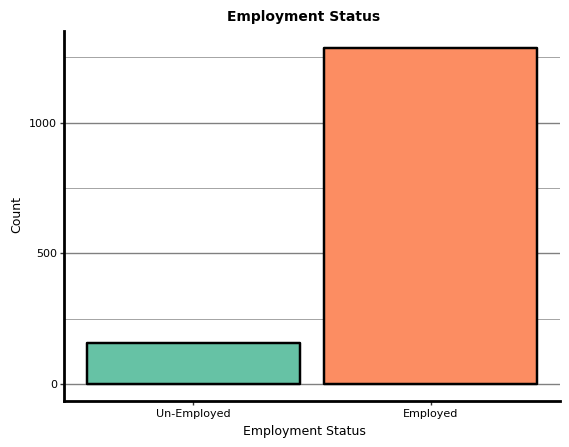

<ggplot: (745162590)>

In [1184]:
(ggplot(df, aes(x = "isEmployed", fill = "factor(isEmployed)"))
    + geom_bar(color = "black", size = 1)
    + ggtitle("Employment Status")
    + labs(x = "Employment Status", y = "Count")
    + scale_x_continuous(breaks = (0,1), labels = ['Un-Employed', 'Employed'])
    + scale_fill_brewer(type ='qual', palette='Set2')
    + theme( # Customizes grid
        axis_line = element_line(size = 2, color = "black"),
        panel_border = element_blank(), 
        panel_background = element_blank(), 
        panel_grid_major_y = element_line(color = "gray", size = 1),
        panel_grid_minor_y = element_line(color = "gray", size = 0.5),
    )
    + theme( # Customizes text
        plot_title = element_text(size = 10, face = "bold"),
        text = element_text(size = 9),
        axis_text_x = element_text(color="black", size = 8),
        axis_text_y = element_text(color="black", size = 8),
        legend_position = "none",
))

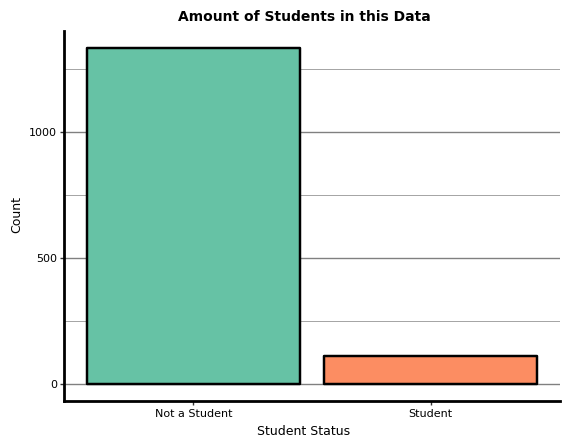

<ggplot: (746088686)>

In [1185]:
(ggplot(df, aes(x = "StudentStatus", fill = "factor(StudentStatus)"))
    + geom_bar(color = "black", size = 1)
    + ggtitle("Amount of Students in this Data")
    + labs(x = "Student Status", y = "Count")
    + scale_x_continuous(breaks = (0,1), labels = ['Not a Student', 'Student'])
    + scale_fill_brewer(type ='qual', palette='Set2')
    + theme( # Customizes grid
        axis_line = element_line(size = 2, color = "black"),
        panel_border = element_blank(), 
        panel_background = element_blank(), 
        panel_grid_major_y = element_line(color = "gray", size = 1),
        panel_grid_minor_y = element_line(color = "gray", size = 0.5),
    )
    + theme( # Customizes text
        plot_title = element_text(size = 10, face = "bold"),
        text = element_text(size = 9),
        axis_text_x = element_text(color="black", size = 8),
        axis_text_y = element_text(color="black", size = 8),
        legend_position = "none",
))

In [1186]:
# Preparing variables for supervised models
predictors = ['Male','Female','Age',
    'PhD', 'bachelors', 'high_school', 'masters', 'professional',
    'some_college', 'campus_recruitment', 'job_board', 'recruiter',
    'referral']
continuous_variables = ['Age']

X = df[predictors]
y = df['isEmployed']

In [1187]:
#80/10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# zscore (only continous and interval variables)
z = StandardScaler()
X_train[continuous_variables] = z.fit_transform(X_train[continuous_variables])
X_test[continuous_variables] = z.transform(X_test[continuous_variables]) 

In [1188]:
# Logistic Regression Model
lr = LogisticRegression()
lr.fit(X_train, y_train) # test set should never see the inside of a .fit


LogisticRegression()

In [1189]:
# Performance Metrics
print("Train Acc: ", accuracy_score(y_train, lr.predict(X_train)))
print("Test Acc: ", accuracy_score(y_test, lr.predict(X_test)))

print("TRAIN Precision: ", precision_score(y_train, lr.predict(X_train)))
print("TEST Precision : ", precision_score(y_test, lr.predict(X_test)))

print("TRAIN Recall: ", recall_score(y_train, lr.predict(X_train)))
print("TEST Recall : ", recall_score(y_test, lr.predict(X_test)))

print("TRAIN ROC/AUC: ", roc_auc_score(y_train, lr.predict_proba(X_train)[:,1]))
print("TEST ROC/AUC : ", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

Train Acc:  0.9479166666666666
Test Acc:  0.9065743944636678
TRAIN Precision:  0.9515377446411929
TEST Precision :  0.9163636363636364
TRAIN Recall:  0.9922254616132167
TEST Recall :  0.984375
TRAIN ROC/AUC:  0.9075469909218042
TEST ROC/AUC :  0.8322088068181819


In [1190]:
# Coefficient values from the LR model
coefficients = pd.DataFrame({
    "Coefficients": lr.coef_[0],
    "Name": predictors
})

# Create a dictionary to easily identify positive and negative values
color_values = {}
for coef, name in coefficients[["Coefficients", "Name"]].values:
    if coef > 0:
        color_values[str(name)] = "green"
    else:
        color_values[str(name)] = "red"

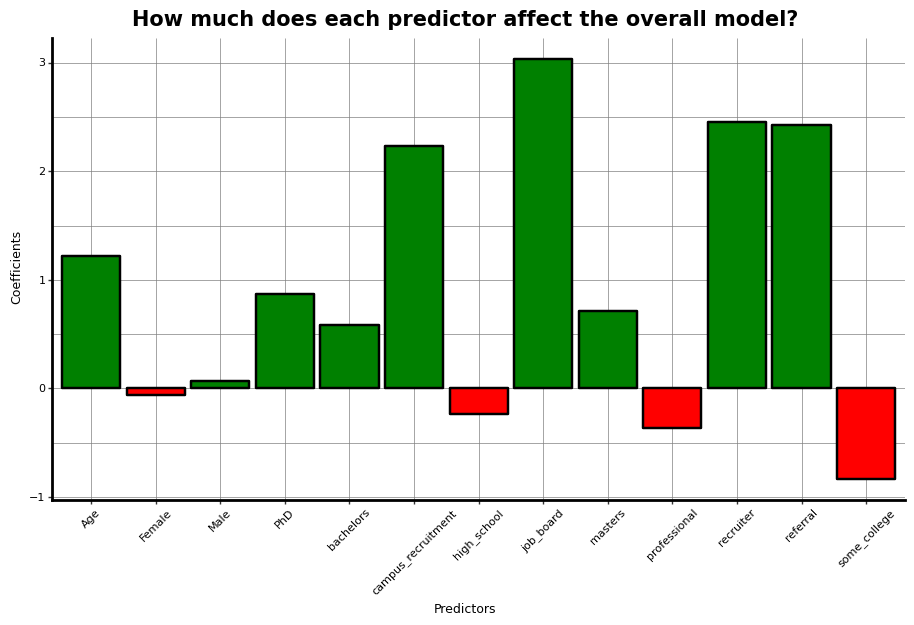

<ggplot: (745609961)>

In [1191]:
(ggplot(coefficients, aes(x = "Name", y = "Coefficients", fill = "factor(Name)"))
    + scale_fill_manual(values = color_values)
    + geom_bar(stat = "identity", position = "identity", color = "black", size = 1)
    + labs(x = "Predictors", y = "Coefficients") 
    + ggtitle("How much does each predictor affect the overall model?")
    + labs(x = "Predictors")
    + theme( # Customizes grid
        axis_line = element_line(size = 2, color = "black"),
        panel_border = element_blank(), 
        panel_background = element_blank(), 
        panel_grid_major_y = element_line(color = "gray", size = 0.5),
        panel_grid_minor_y = element_line(color = "gray", size = 0.5),
        panel_grid_major_x = element_line(color = "gray", size = 0.5),
    )
    + theme( # Customizes text
        plot_title = element_text(size = 15, face = "bold"),
        text = element_text(size = 9),
        axis_text_x = element_text(color="black", size = 8),
        axis_text_y = element_text(color="black", size = 8),
        legend_position = "none",
        )
    + theme(
        figure_size = (11, 6), 
        axis_text_x = element_text(rotation=45))
)

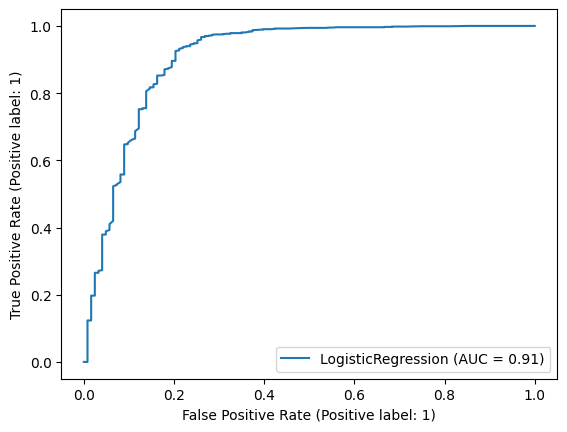

In [1192]:
# ROC Curve for LR
plot_roc_curve(lr, X_train, y_train)

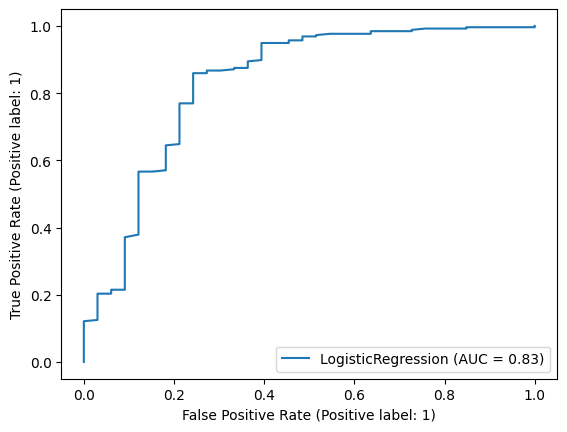

In [1193]:
# ROC Curve for LR
plot_roc_curve(lr, X_test, y_test)

In [1194]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

print("TRAIN: ", mean_absolute_error(y_train, lasso_model.predict(X_train)))
print("TEST : ", mean_absolute_error(y_test, lasso_model.predict(X_test)))

TRAIN:  0.19074164496527782
TEST :  0.1965740340253749


In [1195]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

print("TRAIN: ", mean_absolute_error(y_train, ridge_model.predict(X_train)))
print("TEST : ", mean_absolute_error(y_test, ridge_model.predict(X_test)))

TRAIN:  0.13530553395204592
TEST :  0.16380733991435736


In [1196]:
# LASSO
predictors = ['Male','Female','Age', 'CompensationAmount',
    'PhD', 'bachelors', 'high_school', 'masters', 'professional',
    'some_college', 'campus_recruitment', 'job_board', 'recruiter',
    'referral']
continuous_variables = ['Age', 'CompensationAmount']

X = df[predictors]
y = df['isEmployed']

#80/10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# zscore (only continous and interval variables)
z = StandardScaler()
X_train[continuous_variables] = z.fit_transform(X_train[continuous_variables])
X_test[continuous_variables] = z.transform(X_test[continuous_variables]) 

lsr_tune = LassoCV(cv = 5).fit(X_train,y_train)
# lsr_tune = LassoCV(cv = 5, alphas = [0.001,0.01,0.05,1]).fit(X_train,y_train)

print("TRAIN: ", mean_absolute_error(y_train, lsr_tune.predict(X_train)))
print("TEST : ", mean_absolute_error(y_test, lsr_tune.predict(X_test)))

print("\nwe chose " + str(lsr_tune.alpha_) + " as our alpha.")

TRAIN:  0.1379179057723383
TEST :  0.15075342252663654

we chose 8.855552457675415e-05 as our alpha.


In [1197]:
# Ridge tuning
predictors = ['Male','Female','Age', 'CompensationAmount',
    'PhD', 'bachelors', 'high_school', 'masters', 'professional',
    'some_college', 'campus_recruitment', 'job_board', 'recruiter',
    'referral']
continuous_variables = ['Age', 'CompensationAmount']

X = df[predictors]
y = df['isEmployed']

#80/10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# zscore (only continous and interval variables)
z = StandardScaler()
X_train[continuous_variables] = z.fit_transform(X_train[continuous_variables])
X_test[continuous_variables] = z.transform(X_test[continuous_variables]) 

rr_tune = RidgeCV(cv = 5).fit(X_train,y_train)

print("TRAIN: ", mean_absolute_error(y_train, rr_tune.predict(X_train)))
print("TEST : ", mean_absolute_error(y_test, rr_tune.predict(X_test)))

print("\nwe chose " + str(rr_tune.alpha_) + " as our alpha.")

TRAIN:  0.143832503109308
TEST :  0.14030335503393682

we chose 0.1 as our alpha.


In [1198]:
# Coefficient values from the LR model
ridge_coefficients = pd.DataFrame({
    "Coefficients": rr_tune.coef_,
    "Name": predictors
})

# Create a dictionary to easily identify positive and negative values
ridge_color_values = {}
for coef, name in ridge_coefficients[["Coefficients", "Name"]].values:
    if coef > 0:
        color_values[str(name)] = "green"
    else:
        color_values[str(name)] = "red"

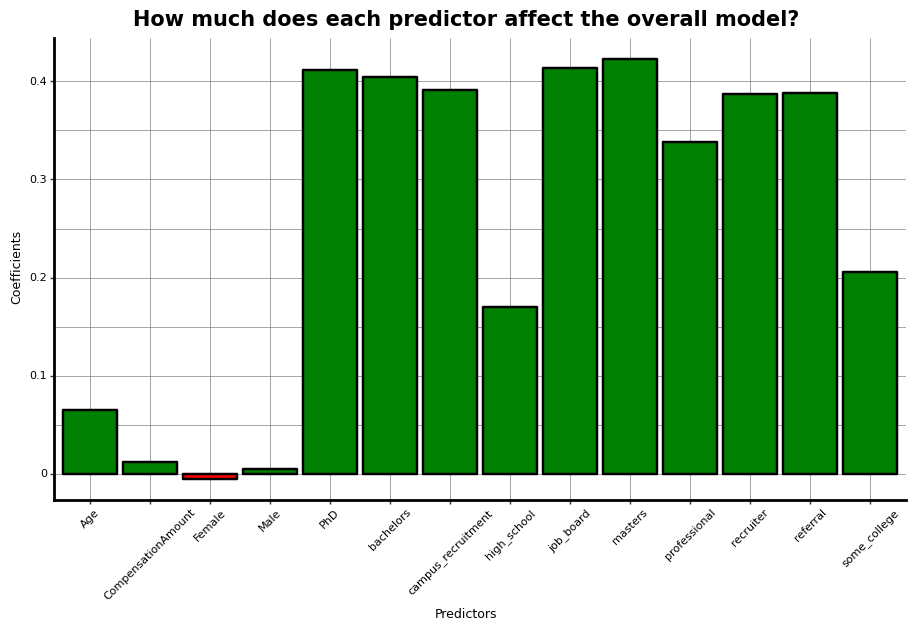

<ggplot: (747611281)>

In [1199]:
(ggplot(ridge_coefficients, aes(x = "Name", y = "Coefficients", fill = "factor(Name)"))
    + scale_fill_manual(values = color_values)
    + geom_bar(stat = "identity", position = "identity", color = "black", size = 1)
    + labs(x = "Predictors", y = "Coefficients") 
    + ggtitle("How much does each predictor affect the overall model?")
    + labs(x = "Predictors")
    + theme( # Customizes grid
        axis_line = element_line(size = 2, color = "black"),
        panel_border = element_blank(), 
        panel_background = element_blank(), 
        panel_grid_major_y = element_line(color = "gray", size = 0.5),
        panel_grid_minor_y = element_line(color = "gray", size = 0.5),
        panel_grid_major_x = element_line(color = "gray", size = 0.5),
    )
    + theme( # Customizes text
        plot_title = element_text(size = 15, face = "bold"),
        text = element_text(size = 9),
        axis_text_x = element_text(color="black", size = 8),
        axis_text_y = element_text(color="black", size = 8),
        legend_position = "none",
        )
    + theme(
        figure_size = (11, 6), 
        axis_text_x = element_text(rotation=45))
)

In [1200]:
# Coefficient values from the LR model
lasso_coefficients = pd.DataFrame({
    "Coefficients": lsr_tune.coef_,
    "Name": predictors
})

# Create a dictionary to easily identify positive and negative values
lasso_color_values = {}
for coef, name in lasso_coefficients[["Coefficients", "Name"]].values:
    if coef > 0:
        color_values[str(name)] = "green"
    else:
        color_values[str(name)] = "red"


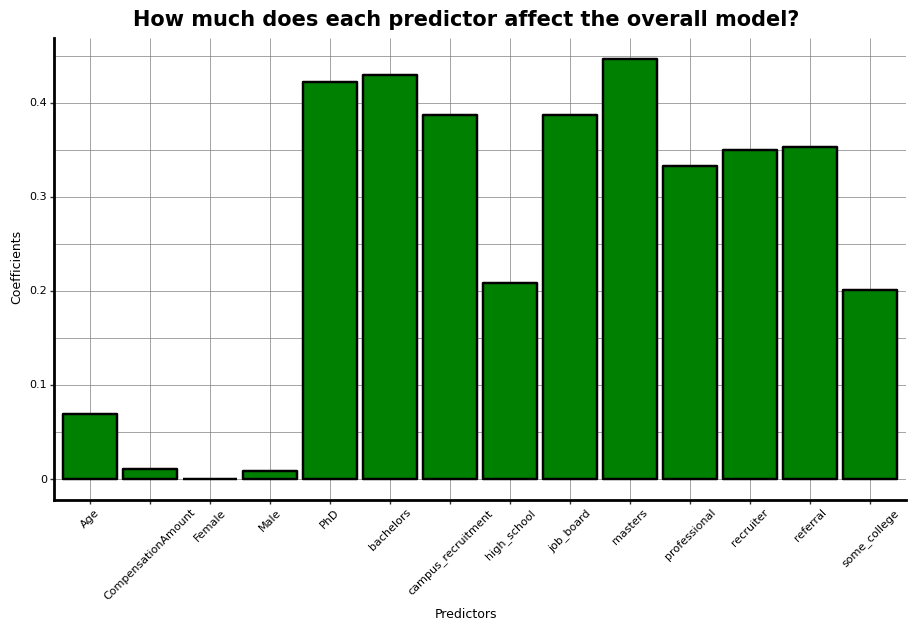

<ggplot: (747565828)>

In [1201]:
(ggplot(lasso_coefficients, aes(x = "Name", y = "Coefficients", fill = "factor(Name)"))
    + scale_fill_manual(values = color_values)
    + geom_bar(stat = "identity", position = "identity", color = "black", size = 1)
    + labs(x = "Predictors", y = "Coefficients") 
    + ggtitle("How much does each predictor affect the overall model?")
    + labs(x = "Predictors")
    + theme( # Customizes grid
        axis_line = element_line(size = 2, color = "black"),
        panel_border = element_blank(), 
        panel_background = element_blank(), 
        panel_grid_major_y = element_line(color = "gray", size = 0.5),
        panel_grid_minor_y = element_line(color = "gray", size = 0.5),
        panel_grid_major_x = element_line(color = "gray", size = 0.5),
    )
    + theme( # Customizes text
        plot_title = element_text(size = 15, face = "bold"),
        text = element_text(size = 9),
        axis_text_x = element_text(color="black", size = 8),
        axis_text_y = element_text(color="black", size = 8),
        legend_position = "none",
        )
    + theme(
        figure_size = (11, 6), 
        axis_text_x = element_text(rotation=45))
)

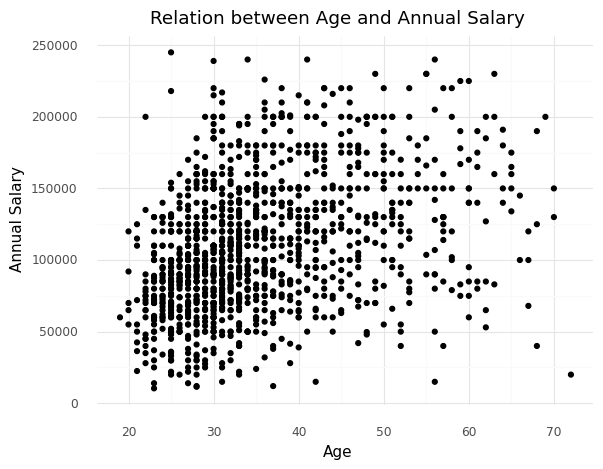

<ggplot: (747595275)>

In [1202]:
# Remove Outliers
df = df[df['CompensationAmount'] < 250_000]
df = df[df['CompensationAmount'] > 10_000]
df = df[df['Age'] > 18]

(ggplot(df, aes(x = "Age", y = "CompensationAmount")) 
    + geom_point() 
    + theme_minimal()
    + ggtitle("Relation between Age and Annual Salary")
    + labs(x = "Age", y = "Annual Salary")
    + theme_minimal()
)

In [1203]:
from sklearn.preprocessing import StandardScaler

features = ['Age', 'CompensationAmount']
z = StandardScaler()

df[features] = z.fit_transform(df[features])
gmm = GaussianMixture(n_components = 3).fit(df[features])
gmm_labels = gmm.predict(df[features])

#labList = ["Cluster " + str(i) for i in range(1, len(set(gmm.labels_)))]

df['assignments'] = gmm_labels

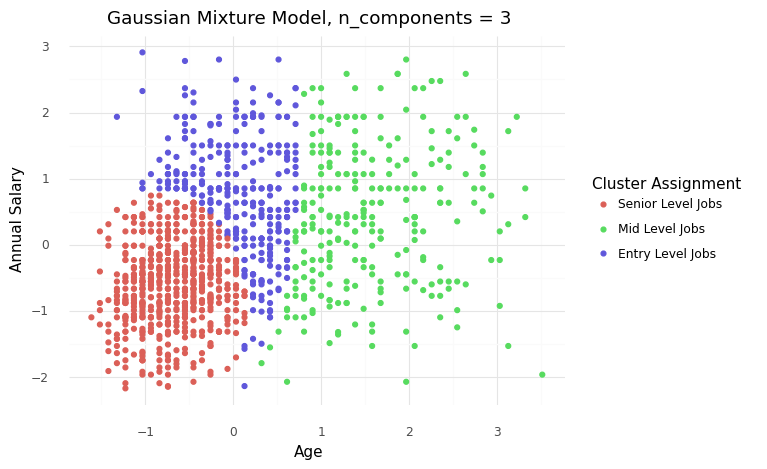

<ggplot: (747595200)>

In [1204]:
(ggplot(df, aes(x = "Age", y = "CompensationAmount", color = "factor(assignments)"))
    + geom_point() 
    + theme_minimal()
    + labs(title = "Gaussian Mixture Model, n_components = 3", x = "Age", y = "Annual Salary")
    + scale_color_discrete(name = "Cluster Assignment", labels = (["Senior Level Jobs", "Mid Level Jobs", "Entry Level Jobs"]))
    + theme_minimal()
)

In [1205]:
ss_gmm = silhouette_score(df[features], df[['assignments']])
print("Silhouette Score for GM Model:", ss_gmm)

Silhouette Score for GM Model: 0.34963370059537546
